In [8]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def show_images(imgs):
    """最大3列で画像表示
    """
    n = len(imgs)
    w = 3
    h = n // w + 1
    plt.figure(figsize=(w*5,h*5))
    for i, img in enumerate(imgs):
        plt.subplot(h, w, i+1)
        if len(img.shape) == 2:
            plt.imshow(img, cmap="gray") # グレイスケール表示
        else:
            plt.imshow(img)
    plt.show()

## 読み込み

In [10]:
def bgr_to_rgb(img):
    return img[:, :, ::-1]

def rgb_to_gray(img):
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    return 0.2989 * r + 0.5870 * g + 0.1140 * b

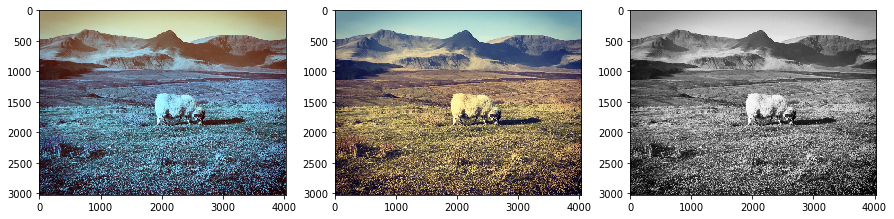

before:  (3022, 4032)
after:  (302, 403)


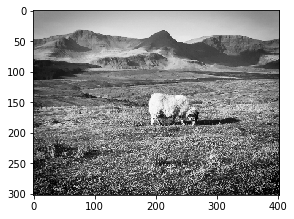

In [11]:
raw_img = cv2.imread("./figures/sample.JPG")
rgb_img = bgr_to_rgb(raw_img)
gray_img = rgb_to_gray(rgb_img)
show_images([raw_img, rgb_img, gray_img])

# resize
print("before: ", gray_img.shape)
size = (gray_img.shape[1]//10, gray_img.shape[0]//10)
gray_img = cv2.resize(gray_img, size)
print("after: ", gray_img.shape)
show_images([gray_img])

## ノイズ付加

In [56]:
def salt_pepper_noise(img, d=0.05):
    img = img.copy()
    h, w = img.shape
    randoms = np.random.random_integers(w*h, size=int(w*h*d))
    for n in randoms:
        i = n // w
        j = n - i*w
        img[i][j] = np.random.choice([0, 255])
    return img

def gaussian_noise(img, d=0.05):
    h, w= img.shape
    mu = 0
    sigma = np.mean(img)*d
    gauss = np.random.normal(mu, sigma, size=(h,w))
    return img+gauss

/Users/arakawariku/.pyenv/versions/miniconda3-3.19.0/envs/ml_env/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 121706 + 1) instead


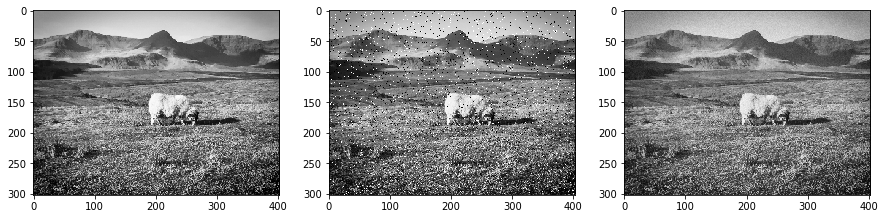

In [57]:
salt_pepper_img = salt_pepper_noise(gray_img)
gaussian_img = gaussian_noise(gray_img)
show_images([gray_img, salt_pepper_img, gaussian_img])